In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.parametrize as parametrize
import matplotlib.pyplot as plt
import numpy as np


In [2]:
#Model Without Parameterization
class LargerModelWithoutParam(nn.Module):
    def __init__(self):
        super(LargerModelWithoutParam, self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x


In [3]:
def apply_positive_weights(model):
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            with torch.no_grad():
                layer.weight.copy_(torch.abs(layer.weight))
#To enforce positive weights manually, we have to do this explicitly during training:
#This manual enforcement has issues:
#It needs to be done repeatedly after each training step.
#There’s no guarantee that weights will remain positive between updates

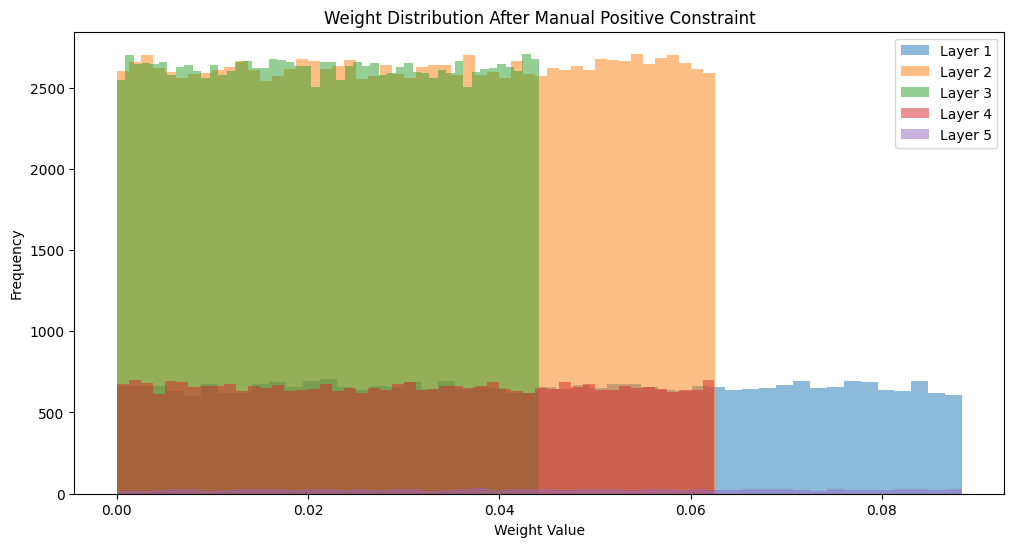

In [4]:
def get_weight_distributions(model):
    weights = []
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            weights.append(layer.weight.detach().cpu().numpy().flatten())
    return weights

model_without_param = LargerModelWithoutParam()

# Apply positive weights
apply_positive_weights(model_without_param)

# Get weight distributions after manual constraint
weights_before = get_weight_distributions(model_without_param)

# Plot the distribution
plt.figure(figsize=(12, 6))
for i, weight in enumerate(weights_before):
    plt.hist(weight, bins=50, alpha=0.5, label=f'Layer {i+1}')
plt.title('Weight Distribution After Manual Positive Constraint')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [6]:
#Implementing Positive Weight Parameterization
class PositiveWeightParametrization(nn.Module):
    def forward(self, X):
        return torch.abs(X)

class LargerModelWithParam(nn.Module):
    def __init__(self):
        super(LargerModelWithParam, self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 10)

        # Registering positive weight parametrization
        parametrize.register_parametrization(self.fc1, "weight", PositiveWeightParametrization())
        parametrize.register_parametrization(self.fc2, "weight", PositiveWeightParametrization())
        parametrize.register_parametrization(self.fc3, "weight", PositiveWeightParametrization())
        parametrize.register_parametrization(self.fc4, "weight", PositiveWeightParametrization())
        parametrize.register_parametrization(self.fc5, "weight", PositiveWeightParametrization())

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x


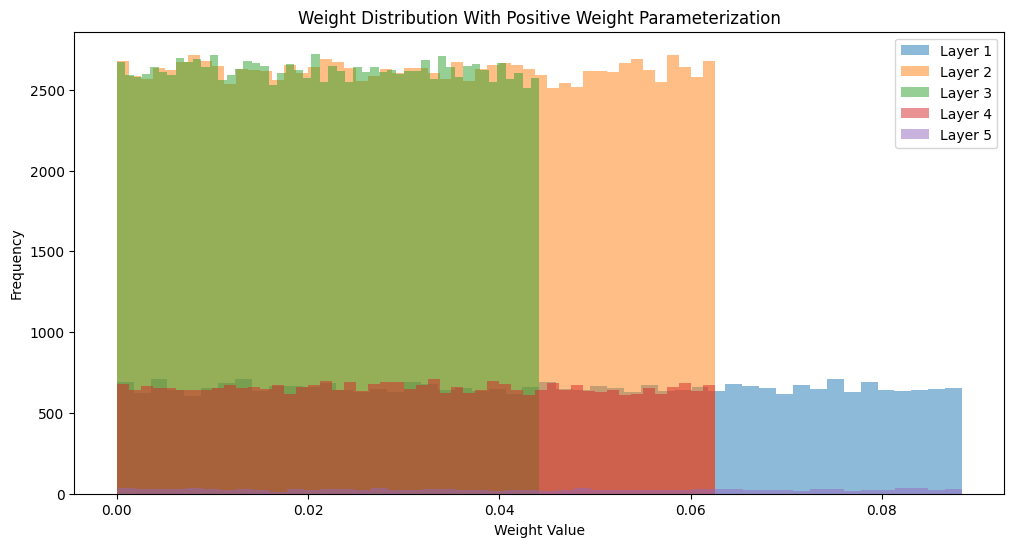

In [7]:
model_with_param = LargerModelWithParam()

# Get weight distributions with parameterization
weights_after = get_weight_distributions(model_with_param)

# Plot the distribution
plt.figure(figsize=(12, 6))
for i, weight in enumerate(weights_after):
    plt.hist(weight, bins=50, alpha=0.5, label=f'Layer {i+1}')
plt.title('Weight Distribution With Positive Weight Parameterization')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [8]:
#By comparing the two approaches:
#Without Parameterization: We had to manually enforce constraints, which was error-prone and required additional handling in the training loop.
#With Parameterization: The positive weight constraint was automatically enforced, making the model code cleaner and ensuring consistent constraint application during training